In [1]:
%load_ext lab_black
%load_ext autotime
import numpy as np
import pandas as pd

time: 243 ms (started: 2022-09-16 23:02:13 -07:00)


**Note**: you should run the `cifar10.ipynb` notebook first, and store the cifar10 data for use here. If you don't, lots of the code here won't run. If you ended up here from searching the internet for how to run inference on cifar10 (or get activations) with pytorch and couldn't care less about `drnb`, you can definitely cobble together enough code to run inference on the version of cifar10 provided with the `torchvision` module.

In the `cifar10` notebook I noted that this is not a dataset that embeds very well in its raw form, but that the activation layer of a convolutional neural network gave quite good results with [Barnes-Hut t-SNE](http://jmlr.org/papers/v15/vandermaaten14a.html). As [PyMDE](https://pymde.org/) uses pytorch as a dependency, that is a convenient library to use to generate some activation data of our own. However, although cifar10 is not a huge dataset by modern standards, it's still time-consuming for a normal person to train it. Fortunately, [Huy Phan](https://github.com/huyvnphan) trained some common CNN architectures with cifar10 *and* shared the weights at <https://github.com/huyvnphan/PyTorch_CIFAR10>. What a mensch!

So we just have to build a network, download the weights, and then run inference with the network on the cifar10 images. That's not that hard. Nonetheless as a pytorch ignoramus, I had to refer to many a website to make this notebook work. If you want to follow in my footsteps:

* <https://github.com/huyvnphan/PyTorch_CIFAR10>
* <https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html>
* <https://jdhao.github.io/2022/03/18/torch_accelerate_batch_inference/>
* <https://discuss.pytorch.org/t/same-input-to-same-trained-model-producing-different-results-each-time/6704>
* <https://docs.databricks.com/_static/notebooks/deep-learning/pytorch-images.html>
* <https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch>

## Defining a CNN architecture

Which architecture to use? Consider this [recent Reddit comment](https://www.reddit.com/r/MachineLearning/comments/xe4fi6/comment/iofq54x/). It mentions VGG in conjunction with UMAP for clustering, and the [PyTorch_CIFAR10](https://github.com/huyvnphan/PyTorch_CIFAR10) put various flavors of that at the top of leaderboard. So we'll use that and specifically `vgg13_bn`.

The code to do this is all [Huy Phan's work](https://github.com/huyvnphan/PyTorch_CIFAR10/blob/641cac24371b17052b9bb6e56af1c83b5e97cd7f/cifar10_models/vgg.py). However, I have simplified the code as we only need one architecture.

In [2]:
import torch
import torch.nn as nn


class VGG(nn.Module):
    def __init__(self, features, classifier):
        super(VGG, self).__init__()
        self.features = features
        # CIFAR 10 (7, 7) to (1, 1)
        # self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = classifier

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers():
    cfg = [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"]
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


def make_classifier():
    num_classes = 10
    return nn.Sequential(
        nn.Linear(512 * 1 * 1, 4096),
        # nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, num_classes),
    )


def load_weights(model, file, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Setting device to {device}")
    state_dict = torch.load(file, map_location=device)
    model.load_state_dict(state_dict)


def vgg13_bn(weights_file, device=None):
    """VGG 13-layer model (configuration "B") with batch normalization"""
    features = make_layers()
    classifier = make_classifier()
    model = VGG(features, classifier)

    load_weights(model, weights_file, device=device)
    return model

time: 455 ms (started: 2022-09-16 23:02:19 -07:00)


## Grab the pretrained weights and build the network

Again, these weights are all from data pointed to from <https://github.com/huyvnphan/PyTorch_CIFAR10>:

In [3]:
import zipfile
from io import BytesIO

import requests


def get_model(device="cpu"):
    url = "https://rutgers.box.com/shared/static/gkw08ecs797j2et1ksmbg1w5t3idf5r5.zip"
    req = requests.get(url)
    with zipfile.ZipFile(BytesIO(req.content)) as zip_file:
        with zip_file.open("state_dicts/vgg13_bn.pt") as weights_file:
            return vgg13_bn(weights_file=weights_file, device=device)

time: 39.8 ms (started: 2022-09-16 23:02:22 -07:00)


In [4]:
# If you don't have a GPU use model_cpu instead
# model_cpu = get_model(device="cpu")
model_cuda = get_model(device="cuda")

time: 1min 2s (started: 2022-09-16 23:03:01 -07:00)


## Create a dataset

Adapting data for use with pytorch requires extending the [torch.utils.data.Dataset](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#Dataset) class. You only need to implement two methods: `__len__` to return the number of items in the dataset, and `__getitem__`, which should return a specific item correctly transformed and ready to be shoved down the network. That means making it a [tensor](https://pytorch.org/docs/stable/tensors.html) and doing whatever scaling and centering was done to the training data. Fortunately the [CIFAR10 torchvision source](https://pytorch.org/vision/stable/_modules/torchvision/datasets/cifar.html#CIFAR10) is very clear to guide our efforts.

In [6]:
from torchvision import transforms as T

import drnb.io.dataset as drnb_data


class Cifar10Dataset(torch.utils.data.Dataset):
    # train=True: training; train=False: test; train=<int>: data[:train]; train=None: train+test
    def __init__(self, train=None):
        self.mean = (0.4914, 0.4822, 0.4465)
        self.std = (0.2471, 0.2435, 0.2616)

        drnb_cifar10 = drnb_data.read_data("cifar10", sub_dir="data")
        if train is not None:
            # must check if train is boolean first because booleans are also considered ints
            if isinstance(train, bool):
                if train:
                    drnb_cifar10 = drnb_cifar10[:50000]
                else:
                    drnb_cifar10 = drnb_cifar10[50000:]
            else:
                drnb_cifar10 = drnb_cifar10[:train]
        self.data = (
            drnb_cifar10.astype(np.uint8)
            .reshape(drnb_cifar10.shape[0], 3, 32, 32)
            .transpose(0, 2, 3, 1)
        )

    def __getitem__(self, index):
        return T.Compose(
            [
                T.ToTensor(),
                T.Normalize(self.mean, self.std),
            ]
        )(self.data[index,])

    def __len__(self):
        return self.data.shape[0]


cifar10_dataset = Cifar10Dataset()
len(cifar10_dataset)

60000

time: 1.32 s (started: 2022-09-16 23:04:28 -07:00)


Just check that we can still get back the original images and we haven't mangled the data as it was adapted to be a pytorch `Dataset`:

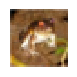

time: 529 ms (started: 2022-09-16 23:04:36 -07:00)


In [7]:
import matplotlib.pyplot as plt


def view_cifar(cifar10, idx):
    plt.figure(figsize=(0.75, 0.75))
    plt.axis("off")
    plt.imshow(
        cifar10.data[idx],
        interpolation="nearest",
        vmin=0,
        vmax=255,
    )


view_cifar(cifar10_dataset, 0)

If you can see a blurry image of a frog, all is well. If you *can't*, you may actually still be ok: it's really not that easy to make out the cifar10 images.

## Using the torchvision CIFAR10 instead

For debugging (or you just don't want to do the processing laid out in the `cifar10.ipynb` dataset yourself), you can use this function to use the torchvision cifar10 instead (it should give the same results). You must provide `root`, the path to where you want the data downloaded to.

In [9]:
from torchvision.datasets import CIFAR10


def get_cifar10_tv(root, train=False):
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2471, 0.2435, 0.2616)
    return CIFAR10(
        root=root,
        train=train,
        transform=T.Compose(
            [
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        ),
    )

time: 4.72 ms (started: 2022-09-16 23:04:44 -07:00)


## Get the real labels

If you use the pytorch `CIFAR10` class, the labels are returned as the second item of a tuple when you call e.g. `cifar10_tv[0]`. But I will use previously curated target data from `drnb`:

In [10]:
cifar10_target = drnb_data.read_target("cifar10", sub_dir="data")

time: 34.3 ms (started: 2022-09-16 23:04:52 -07:00)


## Find the activation layer

Look at the `model_cuda`'s string representation:

In [11]:
model_cuda

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

time: 3.58 ms (started: 2022-09-16 23:04:55 -07:00)


I want the layer right before the `classifier` part: that's called `avgpool`. It's not really clear to me from the definition of `avgpool` itself what size it is, but the `Linear` layer straight after in the `classifier` section says `in_features=512`, so I guessed it consisted of `512` values.

## Making predictions

Now to run inference with the model. Although inference is a lot faster than training, it's still slow on a CPU relative to a GPU. I estimate that if I had tried to do inference with the CPU on all of cifar10, it would have taken about ten minutes. Conversely on a GPU (a 1080 in a laptop, so hardly cutting edge) it only takes ten seconds. I recommend fiddling with `batch_size` and `num_workers` depending on your
CPU or GPU. `batch_size` had the most noticeable effect.

Because I am mainly interested in the activations, by default the activations are also returned.

In [12]:
from torch.utils.data import DataLoader


def get_predictions(
    model,
    dataset,
    device=None,
    batch_size=None,
    num_workers=None,
    with_activations=True,
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device {device}")
    if device == "cuda":
        model.cuda()
        torch.backends.cudnn.benchmark = True
        if num_workers is None:
            num_workers = 2
        if batch_size is None:
            batch_size = 32
        pin_memory = True
    else:
        dataloader_kwargs = dict(num_workers=0)
        if num_workers is None:
            num_workers = 0
        if batch_size is None:
            batch_size = 64
    dataloader_kwargs = dict(
        num_workers=num_workers, pin_memory=pin_memory, batch_size=batch_size
    )

    device = torch.device(device)
    data_loader = DataLoader(dataset, **dataloader_kwargs)

    n_batches = len(data_loader)
    n_predictions = len(dataset)

    predicted_labels = np.empty(n_predictions, dtype=np.uint8)
    # if you use the torchvision of Cifar10 you can get the actual labels back
    # useful for debugging
    actual_labels = np.empty(n_predictions, dtype=np.uint8)

    # register a hook which will store the activation values for each batch
    # this is where we need to know that `avgpool` is they layer we want to get data out of
    activation_ndim = 512
    activation_layer = {}
    activations = None
    if with_activations:
        activations = np.empty((n_predictions, activation_ndim), dtype=np.float32)

        def store_values(model, input, output):
            activation_layer["values"] = output.detach()

        model.avgpool.register_forward_hook(store_values)

    # loop through batches

    model.eval()
    batch_begin = 0
    with torch.no_grad():
        for batch in data_loader:
            batch_labels = None

            # torchvision Cifar10 will return actual labels in the second item in the tuple
            if isinstance(batch, list):
                batch_labels = batch[1]
                batch = batch[0]

            actual_batch_size = batch.shape[0]
            batch_end = batch_begin + actual_batch_size

            # save the torchvision labels here
            if batch_labels is not None:
                actual_labels[batch_begin:batch_end] = batch_labels

            predictions = model(batch.to(device))
            predicted_labels[batch_begin:batch_end] = np.argmax(
                predictions.detach().cpu().numpy().reshape((actual_batch_size, 10)),
                axis=1,
            )

            if with_activations:
                activations[batch_begin:batch_end] = (
                    activation_layer["values"]
                    .cpu()
                    .numpy()
                    .reshape((actual_batch_size, activation_ndim))
                )
            batch_begin += actual_batch_size
    if with_activations:
        return predicted_labels, activations, actual_labels
    return predicted_labels, actual_labels

time: 14.4 ms (started: 2022-09-16 23:05:11 -07:00)


In [13]:
predicted_labels, activations, _ = get_predictions(
    model_cuda, cifar10_dataset, device="cuda"
)

time: 13.4 s (started: 2022-09-16 23:05:14 -07:00)


Let's just check the accuracy of the predictions to make sure the activations aren't completely hopeless:

In [14]:
np.sum(predicted_labels == cifar10_target["labels"]) / len(cifar10_dataset)

0.99015

time: 6.93 ms (started: 2022-09-16 23:05:45 -07:00)


Yeah, that seems pretty good. Note that we are using the combined training and test set here. Prediction on just the test set is "only" 94%.

In [15]:
predicted_test_labels, _ = get_predictions(
    model_cuda, Cifar10Dataset(train=False), device="cuda", with_activations=False
)
np.sum(predicted_test_labels == cifar10_target[50000:]["labels"]) / 10000

0.9421

time: 2.47 s (started: 2022-09-16 23:05:48 -07:00)


In [16]:
activations.shape, activations[0, :10]

((60000, 512),
 array([0.        , 0.        , 0.00283639, 0.        , 0.00380663,
        0.00815624, 0.        , 0.        , 0.00249664, 0.        ],
       dtype=float32))

time: 3.61 ms (started: 2022-09-16 23:05:55 -07:00)


## Pipeline

In [18]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True).run(
    "cifar10act",
    data=activations,
    target=cifar10_target,
    tags=["activations"],
    url="https://github.com/huyvnphan/PyTorch_CIFAR10",
    verbose=True,
)

[23:11:24] INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=612757;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=963405;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#392\392]8;;\

           INFO     Initial data shape: (60000, 512)                                                 ]8;id=442815;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=984249;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#80\80]8;;\

           INFO     Keeping all columns                                                            ]8;id=531932;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=288844;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Data shape after filtering columns: (60000, 512)                                ]8;id=737112;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=194623;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#151\151]8;;\

           INFO     Removing rows with NAs                                                          ]8;id=997251;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=817839;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#135\135]8;;\

           INFO     Data shape after filtering NAs: (60000, 512)                                    ]8;id=246934;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=252534;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#146\146]8;;\

[23:11:25] INFO     Checked for duplicates: found 0                                                 ]8;id=564075;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=215412;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#158\158]8;;\

           INFO     No scaling                                                                     ]8;id=35808;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=214958;file:///home/james/dev/drnb/src/drnb/preprocess.py#25\25]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=929188;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=697551;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#163\163]8;;\

           INFO     Writing data for cifar10act                                                     ]8;id=583612;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=194981;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

[23:12:22] INFO     Processing target with initial shape (60000, 2)                                 ]8;id=967272;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=265895;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#196\196]8;;\

           INFO     Keeping all columns                                                            ]8;id=927351;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=133746;file:///home/james/dev/drnb/src/drnb/preprocess.py#62\62]8;;\

           INFO     Writing target for cifar10act                                                   ]8;id=561254;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=854384;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#225\225]8;;\

           INFO     Calculating nearest neighbors                                                   ]8;id=938343;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=140219;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#240\240]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and params: {}           ]8;id=228505;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=463257;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#71\71]8;;\

           INFO     Loading faiss with AVX2 support.                                                   ]8;id=132062;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=221143;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=958328;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=238353;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=849835;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=689730;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=947304;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=826119;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

[23:13:37] INFO     Calculating triplets                                                            ]8;id=356112;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=697549;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#276\276]8;;\

[23:13:43] INFO     Writing csv format to triplets/cifar10act.5.1337.idx.csv                        ]8;id=972755;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=891660;file:///home/james/dev/drnb/src/drnb/io/__init__.py#221\221]8;;\

[23:13:45] INFO     Writing csv format to triplets/cifar10act.5.1337.l2.csv                         ]8;id=205748;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=943076;file:///home/james/dev/drnb/src/drnb/io/__init__.py#221\221]8;;\

[23:13:49] INFO     Writing numpy format to triplets/cifar10act.5.1337.idx.npy                      ]8;id=706872;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=15976;file:///home/james/dev/drnb/src/drnb/io/__init__.py#244\244]8;;\

           INFO     Writing numpy format to triplets/cifar10act.5.1337.l2.npy                       ]8;id=37243;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=180676;file:///home/james/dev/drnb/src/drnb/io/__init__.py#244\244]8;;\

[23:13:50] INFO     Writing pipeline result for cifar10act                                          ]8;id=926424;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=573916;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#128\128]8;;\

time: 2min 29s (started: 2022-09-16 23:11:20 -07:00)
